<a href="https://colab.research.google.com/github/ovozzx/Deep_Learning/blob/master/%EC%9E%90%EB%8F%99%EC%B0%A8_%EC%97%B0%EB%B9%84_%EC%98%88%EC%B8%A1(%ED%9A%8C%EA%B7%80).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Linear Regression과 DNN 모델로 연비 예측 비교
https://gmnam.tistory.com/183

In [101]:
import pathlib

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

2.7.0


# 0. 데이터 구하기


In [102]:
#get_file : Downloads a file from a URL
#fname : Name of the file -> auto-mpg.data
#(절대경로로 쓰면 그 경로에 저장됨, 그렇지 않으면 URL에 있는 파일로 사용됨 )
#origin : Original URL of the file -> "http://archive~
dataset_path = keras.utils.get_file("auto-mpg.data", "http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data")
dataset_path

'/root/.keras/datasets/auto-mpg.data'

In [103]:
#mpg : 갤런당 마일 (연비)
column_names = ['MPG','Cylinders','Displacement','Horsepower','Weight',
                'Acceleration', 'Model Year', 'Origin']
raw_dataset = pd.read_csv(dataset_path, names=column_names,
                      na_values = "?", comment='\t',
                      sep=" ", skipinitialspace=True)

dataset = raw_dataset.copy()
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


# 1. 데이터 전처리

In [104]:

#isna()-> 1 or 0
dataset.isna().sum()

MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

In [105]:
#dropna() -> 비어있는 데이터 삭제
#dropna(subset = ['컬럼명'])
dataset = dataset.dropna()

In [106]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 392 entries, 0 to 397
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   MPG           392 non-null    float64
 1   Cylinders     392 non-null    int64  
 2   Displacement  392 non-null    float64
 3   Horsepower    392 non-null    float64
 4   Weight        392 non-null    float64
 5   Acceleration  392 non-null    float64
 6   Model Year    392 non-null    int64  
 7   Origin        392 non-null    int64  
dtypes: float64(5), int64(3)
memory usage: 27.6 KB


In [107]:
#pop -> index값 반환하고 삭제
origin = dataset.pop('Origin')

In [108]:
#origin == n(1~3) -> 0 or 1 
dataset['USA'] = (origin == 1)*1.0
dataset['Europe'] = (origin == 2)*1.0
dataset['Japan'] = (origin == 3)*1.0
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,USA,Europe,Japan
393,27.0,4,140.0,86.0,2790.0,15.6,82,1.0,0.0,0.0
394,44.0,4,97.0,52.0,2130.0,24.6,82,0.0,1.0,0.0
395,32.0,4,135.0,84.0,2295.0,11.6,82,1.0,0.0,0.0
396,28.0,4,120.0,79.0,2625.0,18.6,82,1.0,0.0,0.0
397,31.0,4,119.0,82.0,2720.0,19.4,82,1.0,0.0,0.0


# 2. 데이터셋을 훈련 세트와 테스트 세트(최종 평가)로 분할하기

In [109]:
#sample(frac = 원본 데이터프레임에서 임의로 추출할 행 또는 열의 비율, random_state = 정수이면 모든 반복에서 동일한 수의 행 또는 열을 반환) -> 추출
train_dataset = dataset.sample(frac=0.8,random_state=0)
test_dataset = dataset.drop(train_dataset.index) #전체 데이터에서 train 데이터 제거

In [110]:
train_dataset.index[:]

Int64Index([146, 282,  69, 378, 331, 257, 310, 328, 125, 108,
            ...
            171,  70, 307,  49, 209, 281, 229, 150, 145, 182],
           dtype='int64', length=314)

In [111]:
test_dataset.tail()
#MPG(연비)/ Cylinders(엔진 실린더 수) / Displacement(배기량) / 마력 / 무게

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,USA,Europe,Japan
369,34.0,4,112.0,88.0,2395.0,18.0,82,1.0,0.0,0.0
375,36.0,4,105.0,74.0,1980.0,15.3,82,0.0,1.0,0.0
382,34.0,4,108.0,70.0,2245.0,16.9,82,0.0,0.0,1.0
384,32.0,4,91.0,67.0,1965.0,15.7,82,0.0,0.0,1.0
396,28.0,4,120.0,79.0,2625.0,18.6,82,1.0,0.0,0.0


# 3. 데이터 조사하기

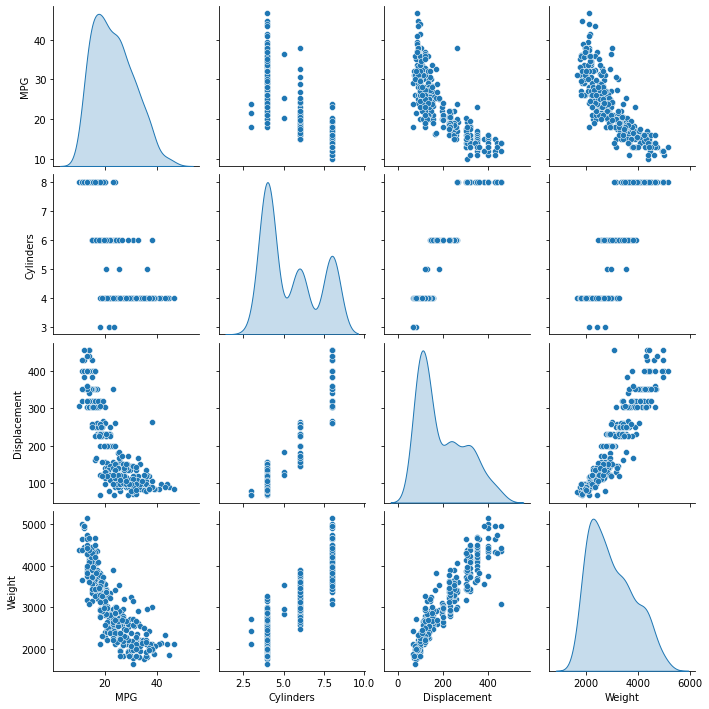

In [112]:
#훈련 세트에서 몇 개의 열 선택 -> 산점도 행렬
#MPG(연비)/ Cylinders(엔진 실린더) / Displacement(배수량) 
#diag_kind(기본값 히스토그램) = kde(density plot)
sns.pairplot(train_dataset[["MPG", "Cylinders", "Displacement", "Weight"]], diag_kind="kde")

In [113]:
train_stats = train_dataset.describe()
train_stats.pop("MPG")
train_stats = train_stats.transpose() # 행&열 바꿈
train_stats

,count,mean,std,min,25%,50%,75%,max
Cylinders,314.0,5.477707,1.699788,3.0,4.00,4.0,8.00,8.0
Displacement,314.0,195.318471,104.331589,68.0,105.50,151.0,265.75,455.0
Horsepower,314.0,104.869427,38.096214,46.0,76.25,94.5,128.00,225.0
Weight,314.0,2990.251592,843.898596,1649.0,2256.50,2822.5,3608.00,5140.0
Acceleration,314.0,15.559236,2.789230,8.0,13.80,15.5,17.20,24.8
Model Year,314.0,75.898089,3.675642,70.0,73.00,76.0,79.00,82.0
USA,314.0,0.624204,0.485101,0.0,0.00,1.0,1.00,1.0
Europe,314.0,0.178344,0.383413,0.0,0.00,0.0,0.00,1.0
Japan,314.0,0.197452,0.398712,0.0,0.00,0.0,0.00,1.0


In [114]:
train_labels = train_dataset.pop('MPG')
test_labels = test_dataset.pop('MPG')

# 4. 정규화

In [115]:
def norm(x):
  return (x - train_stats['mean']) / train_stats['std']
normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

# 5. 모델링

In [116]:
def build_model():
  model = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=[len(train_dataset.keys())]),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)
  ])

  optimizer = tf.keras.optimizers.RMSprop(0.001)

  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

In [117]:
model = build_model()

In [118]:
model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_30 (Dense)            (None, 64)                640       
                                                                 
 dense_31 (Dense)            (None, 64)                4160      
                                                                 
 dense_32 (Dense)            (None, 1)                 65        
                                                                 
Total params: 4,865
Trainable params: 4,865
Non-trainable params: 0
_________________________________________________________________


In [119]:
example_batch = normed_train_data[:10]
example_result = model.predict(example_batch)
example_result

array([[ 0.01045159],
       [ 0.05212687],
       [ 0.05507728],
       [ 0.05013588],
       [ 0.51896644],
       [-0.13130766],
       [ 0.55179226],
       [ 0.5190023 ],
       [-0.2198601 ],
       [ 0.44673306]], dtype=float32)

# 6. 학습

In [120]:
# 에포크가 끝날 때마다 점(.)을 출력해 훈련 진행 과정을 표시합니다
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('*', end='')

EPOCHS = 1000

history = model.fit(
  normed_train_data, train_labels,
  epochs=EPOCHS, validation_split = 0.2, verbose=0,
  callbacks=[PrintDot()])


****************************************************************************************************
****************************************************************************************************
****************************************************************************************************
****************************************************************************************************
****************************************************************************************************
****************************************************************************************************
****************************************************************************************************
****************************************************************************************************
****************************************************************************************************
******************************************************************************************

In [121]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mae,mse,val_loss,val_mae,val_mse,epoch
995,2.474159,1.049696,2.474159,7.728106,2.210523,7.728106,995
996,2.211719,0.947726,2.211719,8.214892,2.267840,8.214892,996
997,2.328349,0.993580,2.328349,7.950925,2.241154,7.950925,997
998,2.481105,1.039632,2.481105,8.018387,2.277676,8.018387,998
999,2.574870,1.053422,2.574870,7.863774,2.224761,7.863774,999


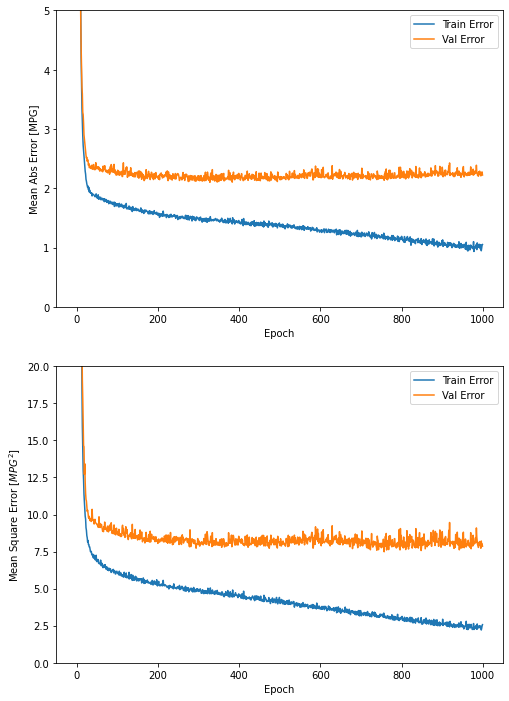

In [122]:
#MAE : 실제값과 예측값의 차이를 절댓값으로 변환해 평균
#MSE : 실제값과 예측값의 차이를 제곱해 평균
#RMSE : MSE에 루트
import matplotlib.pyplot as plt

def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure(figsize=(8,12))

  plt.subplot(2,1,1)
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error [MPG]')
  plt.plot(hist['epoch'], hist['mae'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mae'],
           label = 'Val Error')
  plt.ylim([0,5])
  plt.legend()

  plt.subplot(2,1,2)
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error [$MPG^2$]')
  plt.plot(hist['epoch'], hist['mse'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mse'],
           label = 'Val Error')
  plt.ylim([0,20])
  plt.legend()
  plt.show()

plot_history(history)

# 7. 조기 종료


**************************************************************************

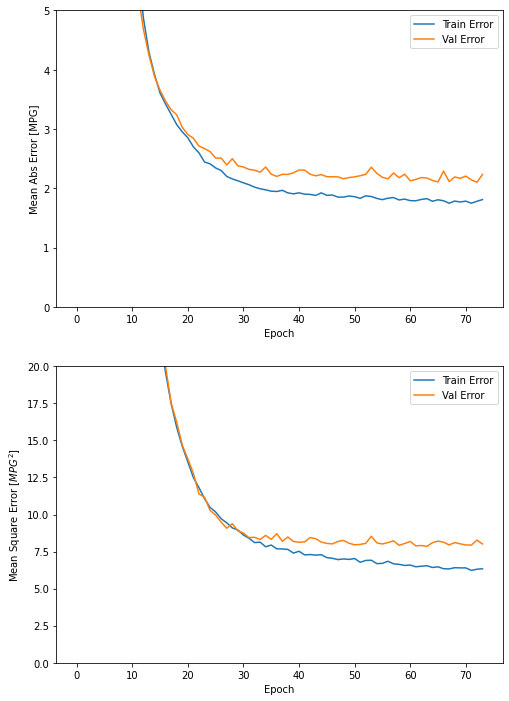

In [123]:
#위의 그래프를 보면 조기종료 필요! (연산 낭비)
model = build_model()

# patience 매개변수는 성능 향상을 체크할 에포크 횟수입니다
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

history = model.fit(normed_train_data, train_labels, epochs=EPOCHS,
                    validation_split = 0.2, verbose=0, callbacks=[early_stop, PrintDot()])

plot_history(history)

# 8. 평가(Test Data)

In [124]:
loss, mae, mse = model.evaluate(normed_test_data, test_labels, verbose=2)

print("테스트 세트의 평균 절대 오차: {:5.2f} MPG".format(mae))

3/3 - 0s - loss: 5.3135 - mae: 1.7391 - mse: 5.3135 - 17ms/epoch - 6ms/step
테스트 세트의 평균 절대 오차:  1.74 MPG


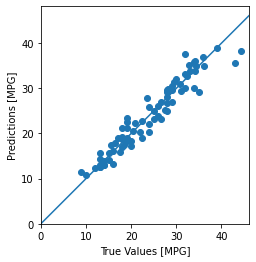

In [125]:
test_predictions = model.predict(normed_test_data).flatten()

plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
_ = plt.plot([-100, 100], [-100, 100])

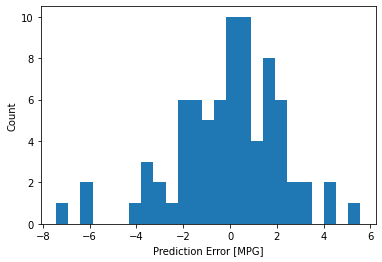

In [126]:
error = test_predictions - test_labels
plt.hist(error, bins = 25)
plt.xlabel("Prediction Error [MPG]")
_ = plt.ylabel("Count")